# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 36449 (delta 160), reused 51 (delta 51), pack-reused 36127 (from 4)
Receiving objects: 100% (36449/36449), 22.26 MiB | 24.83 MiB/s, done.
Resolving deltas: 100% (26264/26264), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical name, but actually scaled down below

# YOLO11n backbone (scaled)
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [16, 3, 2]]              # 0
  - [-1, 1, Conv, [32, 3, 2]]              # 1
  - [-1, 1, C3k2, [64, False, 0.25]]       # 2
  - [-1, 1, Conv, [64, 3, 2]]              # 3
  - [-1, 1, C3k2, [128, False, 0.25]]      # 4  ← P3
  - [4, 1, ECA, [128]]                    # 5

  - [-1, 1, Conv, [128, 3, 2]]             # 6
  - [-1, 1, C3k2, [128, True]]             # 7  ← P4
  - [7, 1, ECA, [128]]                    # 8

  - [-1, 1, Conv, [256, 3, 2]]             # 9
  - [-1, 1, C3k2, [256, True]]             # 10
  - [-1, 1, SPPF, [256, 5]]                # 11
  - [-1, 1, C2PSA, [256]]                  # 12 ← P5
  - [12, 1, ECA, [256]]                   # 13

head:
  - [13, 1, nn.Upsample, [None, 2, "nearest"]]           # 14
  - [[-1, 8], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 16

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 17
  - [[-1, 5], 1, Concat, [1]] 
  - [-1, 1, C3k2, [64, False]]                           # 19

  - [-1, 1, Conv, [64, 3, 2]]                            # 20
  - [[-1, 16], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 22

  - [-1, 1, Conv, [128, 3, 2]]                           # 23
  - [[-1, 13], 1, Concat, [1]]
  - [-1, 1, C3k2, [256, True]]                           # 25

  - [[19, 22, 25], 1, Detect, [nc]]                      # 26
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                   4  1         3  ultralytics.nn.modules.conv.ECA              [128]                         
  6                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]          

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:04<00:00, 108.66it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 144.60it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 91 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.56G       3.73      89.95      3.119         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.75G      4.119      45.71      3.258         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.76G      3.966      18.86      2.194         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.76G      3.715      4.629      1.624         36        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


                   all        200       1017    0.00253      0.116    0.00725    0.00176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.76G      3.577      3.667      1.426         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.182     0.0393     0.0205    0.00412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.76G      3.473      3.253      1.377         17        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017      0.204      0.129     0.0634     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.76G      3.335      2.984       1.31         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


                   all        200       1017      0.224      0.164      0.078      0.016

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.76G      3.325      2.995      1.285          7        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

                   all        200       1017      0.233      0.166     0.0922     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.76G      3.238      2.559      1.272         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


                   all        200       1017      0.276      0.214      0.116     0.0269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.76G      3.274      2.543      1.273         42        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.314      0.132     0.0919     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.76G      3.257      2.414      1.208         68        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.324        0.2      0.138     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.76G      3.177       2.33       1.23         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


                   all        200       1017      0.313      0.251      0.146     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.76G      3.097      2.246      1.196         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


                   all        200       1017      0.281      0.223      0.109     0.0244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.76G      3.103      2.164      1.187         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        200       1017      0.337      0.242      0.162     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.76G      2.998      2.063      1.159         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.417      0.295      0.223     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.76G      3.005      2.024      1.223         31        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017      0.374      0.267      0.195     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.76G      3.059      1.933      1.185         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.351      0.262      0.164     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.76G      2.962      1.963      1.173         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.428      0.311      0.226     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.76G      2.919      1.799      1.141         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]

                   all        200       1017       0.45      0.325      0.249     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.76G      2.965      1.884      1.148         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200       1017      0.361      0.298      0.192     0.0437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.76G      2.869       1.71      1.145         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.356      0.327      0.216     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.76G      2.923      1.759      1.154         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1017      0.468      0.325      0.262     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.76G      2.902      1.747      1.157         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.359      0.312      0.207     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.76G      2.889      1.731      1.135         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


                   all        200       1017      0.407      0.344       0.25     0.0599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.76G      2.887      1.677      1.153         35        640: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.386      0.304      0.221     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.76G      2.844      1.668      1.131         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.482      0.355      0.306      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.76G      2.823      1.605      1.106         15        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.427      0.339      0.261     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.76G        2.8        1.6      1.089         43        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.476      0.382      0.314     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.76G      2.792      1.596      1.121         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017      0.462      0.364      0.291     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.76G      2.749      1.552      1.111         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.456      0.356      0.287     0.0757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.76G      2.835      1.631      1.113         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.408      0.346       0.25     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.76G      2.811      1.501       1.08         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.437      0.349      0.262     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.76G      2.734      1.528      1.082         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.416      0.352      0.286     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.76G      2.764       1.48      1.105         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.436      0.351       0.29     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.76G      2.722       1.46      1.061         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017      0.516      0.381      0.336     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.76G      2.705      1.463      1.114         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.401       0.35      0.269     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.76G      2.744      1.502      1.083         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1017      0.461      0.369      0.315     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.76G      2.637      1.413      1.064         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017      0.459      0.392      0.336      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.76G      2.643        1.4      1.068         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.474       0.36      0.309     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.76G      2.644      1.463      1.103         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017      0.441      0.347      0.278     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.76G      2.663      1.411      1.064         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        200       1017      0.483      0.395      0.352      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.76G      2.682      1.462      1.079         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.497      0.399      0.344     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.76G      2.645      1.364      1.047         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.463      0.383      0.319     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.76G      2.614      1.375      1.083         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        200       1017      0.448      0.377      0.341     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.76G      2.584      1.363      1.066         54        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.422      0.402        0.3     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.76G      2.558      1.332      1.073         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.484      0.396      0.349      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.76G      2.566      1.339      1.055         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200       1017      0.491      0.342      0.303     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.76G      2.549      1.395      1.083         14        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.535      0.394      0.358      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.76G      2.598      1.364      1.053         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        200       1017      0.527       0.37      0.365      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.76G       2.66      1.344      1.054         12        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.514      0.353      0.343     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.76G      2.615       1.36      1.089         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.508        0.4      0.363      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.76G      2.528      1.304      1.077         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017      0.499      0.383      0.353      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.76G      2.565       1.32      1.044         62        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        200       1017      0.547      0.411      0.389      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.76G      2.488      1.304      1.073         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.518       0.41      0.365      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.76G      2.557      1.318       1.06         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.446      0.365      0.305     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.76G      2.507      1.259      1.042         12        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017      0.525      0.403      0.357      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.76G       2.49      1.274      1.054         52        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.551      0.433      0.402       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.76G      2.541       1.28      1.056         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        200       1017      0.552      0.378       0.37      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.76G      2.516      1.279      1.044         34        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


                   all        200       1017      0.508      0.429      0.383      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.76G      2.495      1.265      1.035         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200       1017      0.507      0.414      0.375      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.76G      2.476      1.247      1.039         16        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.512      0.411      0.384      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.76G       2.49      1.257      1.061         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200       1017      0.527      0.398      0.336      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.76G      2.453      1.254      1.029         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.526      0.402       0.38       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.76G      2.431      1.228       1.06         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1017      0.499      0.405      0.386      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.76G       2.49      1.267      1.057         37        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017       0.47      0.403      0.358      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.76G      2.469      1.262       1.07         13        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.496      0.399      0.338     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.76G      2.553      1.279      1.054         62        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.484      0.399      0.353      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.76G      2.507      1.252      1.042         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.533       0.42      0.378      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.76G      2.486      1.188      1.029         50        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        200       1017      0.574      0.431      0.406      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.76G      2.427       1.25       1.05         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        200       1017      0.521      0.418      0.373      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.76G      2.471      1.257      1.043         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.574      0.413        0.4      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.76G      2.403      1.209      1.037         35        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.557       0.44      0.411      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.76G      2.464      1.243      1.056         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017      0.545      0.423      0.397      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.76G      2.399      1.173      1.025         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.535      0.387      0.383      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.76G      2.371      1.184       1.02         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.559      0.445      0.413      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.76G      2.423      1.186      1.019         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017       0.57      0.426      0.409      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.76G      2.389      1.178      1.036         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017       0.51      0.412      0.382      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.76G      2.409      1.227      1.076         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.573      0.432      0.401      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.76G      2.399      1.202      1.051         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        200       1017      0.552      0.428       0.41      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.76G      2.474      1.224      1.032         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.529      0.426      0.405      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.76G      2.417      1.196      1.044         40        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        200       1017      0.463      0.399      0.357      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.76G      2.475      1.215      1.049         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1017      0.511      0.448       0.42      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.76G      2.413      1.185      1.042         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.525      0.416      0.373      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.76G        2.4      1.163      1.029         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

                   all        200       1017      0.501      0.436      0.379      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.76G      2.451      1.211      1.055         45        640: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.513      0.427      0.391      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.76G      2.456       1.25      1.076         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

                   all        200       1017      0.546      0.453      0.419      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.76G      2.362      1.208      1.035         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.588      0.444      0.443      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.76G      2.353      1.168     0.9937         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.559      0.447      0.414      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.76G      2.315      1.155      1.023         65        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.579       0.46      0.452       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.76G       2.34       1.15      1.043         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1017      0.568      0.443      0.429      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.76G      2.441      1.184      1.026         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200       1017      0.519       0.42      0.374      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.76G      2.378      1.142      1.023         53        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017       0.54      0.421      0.385      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.76G      2.365      1.161       1.02         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        200       1017      0.547      0.438      0.415      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.76G      2.298      1.149      1.021         20        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.517      0.444      0.404      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.76G      2.371      1.191      1.038         22        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


                   all        200       1017      0.577      0.465      0.436      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.76G      2.456      1.201      1.067         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.551      0.455      0.419      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.76G       2.33      1.141      1.032         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        200       1017      0.599      0.426       0.44      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.76G      2.364      1.129      1.008         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200       1017      0.543      0.454      0.411      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.76G      2.275      1.137      1.008         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.577      0.439      0.431      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.76G      2.426      1.166      1.026         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all        200       1017      0.567      0.441      0.427      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.76G      2.384      1.164      1.025         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]


                   all        200       1017      0.572      0.436      0.438      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.76G      2.374      1.128      1.018         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1017      0.576      0.472      0.455      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.76G      2.343      1.123      1.015         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200       1017      0.553      0.441       0.42      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.76G      2.335      1.154      1.013         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.503       0.44      0.395      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.76G      2.374      1.172      1.022         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


                   all        200       1017      0.552      0.479      0.442      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.76G      2.359      1.172      1.032         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


                   all        200       1017      0.558      0.468      0.425      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.76G      2.313      1.122      1.018         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017      0.588      0.472       0.44      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.76G      2.371      1.151      1.018         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017      0.547      0.439      0.424      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.76G       2.25      1.104     0.9935         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.553      0.468      0.447      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.76G       2.29      1.081     0.9913         40        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.594      0.466      0.459      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.76G      2.378      1.153      1.012         17        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        200       1017      0.565      0.454      0.439      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.76G      2.398      1.136      1.018         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200       1017      0.588      0.469       0.45      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.76G      2.284      1.107      1.008         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


                   all        200       1017       0.55      0.434      0.408      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.76G      2.297      1.098      1.006         37        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200       1017      0.558       0.44       0.45      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.76G      2.246      1.091       1.03         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.577      0.474      0.456      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.76G      2.282      1.093      1.015         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.566      0.464       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.76G      2.324      1.127     0.9903         37        640: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017       0.58      0.469      0.442      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.76G      2.272      1.073     0.9893         57        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

                   all        200       1017      0.599       0.47       0.45      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.76G       2.26      1.105     0.9863         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.588      0.475      0.457      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.76G      2.317       1.16      1.022         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.586      0.493      0.458      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.76G      2.251       1.09      1.007         31        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.587      0.441      0.439      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.76G      2.215       1.06      1.023         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.588       0.47      0.459      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.76G      2.278      1.089     0.9968         11        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.567      0.458      0.435      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.76G      2.245      1.087     0.9821         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017      0.558      0.457      0.431       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.76G      2.305      1.097     0.9883         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017       0.58      0.475      0.464      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.76G      2.276      1.059      1.019         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.584       0.46      0.453      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.76G       2.27      1.085      1.009         45        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.592      0.475       0.46      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.76G      2.254       1.07      1.011         26        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        200       1017      0.613      0.462      0.466      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.76G      2.292      1.047      1.006         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.586      0.449       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.76G      2.266      1.077       1.03         25        640: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.613      0.478      0.475      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.76G      2.213      1.044     0.9944         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        200       1017      0.614      0.489      0.464      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.76G      2.255      1.054     0.9846         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.611      0.485      0.479      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.76G       2.26      1.083      1.022         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017       0.59      0.465      0.454      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.76G       2.26      1.082     0.9959         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.571      0.453      0.422      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.76G      2.278      1.113      1.008         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017       0.58      0.465      0.445      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.76G       2.17       1.05     0.9781         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.596      0.464       0.46      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.76G      2.245       1.09     0.9921         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200       1017      0.569       0.47      0.459      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.76G      2.286      1.093      1.009         20        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.601      0.479      0.456      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.76G      2.271      1.081     0.9916         35        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.583      0.479      0.473      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.76G      2.242      1.071      1.015         53        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.601      0.472      0.447      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.76G      2.259      1.061     0.9819         31        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200       1017      0.584      0.465      0.469      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.76G      2.141     0.9853      0.982         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017       0.58      0.484      0.465      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.76G      2.164      1.023      1.004         52        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.596      0.478      0.473      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.76G      2.229      1.074      1.037         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        200       1017      0.599      0.487      0.475      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.76G      2.228      1.049      1.007         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        200       1017      0.596       0.48      0.482      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.76G      2.294      1.075     0.9774         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.582      0.459      0.462      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.76G      2.264      1.081     0.9867         44        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.581      0.481      0.466      0.157
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 132, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



147 epochs completed in 0.615 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 5.5MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary (fused): 109 layers, 2,582,356 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


                   all        200       1017      0.609      0.484      0.478      0.166


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f38756eceb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [12]:
!zip -r yolo11_baseline_cbam.zip /kaggle/working/model

updating: kaggle/working/model/ (stored 0%)
updating: kaggle/working/model/train_batch0.jpg (deflated 7%)
updating: kaggle/working/model/args.yaml (deflated 54%)
updating: kaggle/working/model/R_curve.png (deflated 20%)
updating: kaggle/working/model/results.csv (deflated 60%)
updating: kaggle/working/model/confusion_matrix.png (deflated 38%)
updating: kaggle/working/model/val_batch1_pred.jpg (deflated 8%)
updating: kaggle/working/model/results.png (deflated 7%)
updating: kaggle/working/model/val_batch2_pred.jpg (deflated 13%)
updating: kaggle/working/model/labels_correlogram.jpg (deflated 40%)
updating: kaggle/working/model/labels.jpg (deflated 34%)
updating: kaggle/working/model/train_batch2.jpg (deflated 7%)
updating: kaggle/working/model/F1_curve.png (deflated 19%)
updating: kaggle/working/model/train_batch1.jpg (deflated 4%)
updating: kaggle/working/model/P_curve.png (deflated 13%)
updating: kaggle/working/model/val_batch1_labels.jpg (deflated 8%)
updating: kaggle/working/model/va

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 6 humans, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


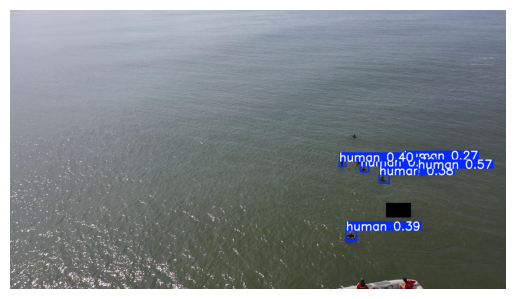

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 817.10it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


                   all        200       1072      0.637       0.58      0.533      0.191


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f395a5548e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [8]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)